# Finetune Pix2Struct model on Rico dataset

## Setup Envirnoment

In [ ]:
!pip install transformers==4.33.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.0 MB/s eta 0:00:00


## Import necessary libraries

In [ ]:
from google.colab import drive
import os
import zipfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import re
from transformers import Pix2StructForConditionalGeneration, AutoProcessor
import torch
from torch.nn import functional as F
from pathlib import Path
from nltk import edit_distance
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from torch.utils.data import random_split
import random
import json
from transformers import GenerationConfig

## Define variables and parameters

In [ ]:

G_DRIVE_FOLDER = '/content/drive/MyDrive/Datasets/'
G_DRIVE_FOLDER_CHECKPOINTS = '/content/drive/MyDrive/Checkpoints/'
DATASET_NAME = 'unique_uis'
DATASET_NAME_UNZIPPED = 'combined'
TAR_NAME = DATASET_NAME + '.tar.gz'


DESTINATION_FOLDER= '/content/'
DATASET_FOLDER = DESTINATION_FOLDER + DATASET_NAME_UNZIPPED + "/"


EXPERIMENT_NAME = "Pix2Struct_Rico_Complete_sampling_TEST"

OUTPUT_FOLDER = '/content/drive/MyDrive/Testing_output/rico_sampling'

EXPERIMENT_NAME = ""

MAX_SENTENCE_LEN = 4096

CHUNK_LENGTH = 1024
CONTEXT_OVERLAP_LENGTH = 256

MAX_PATCHES = 1024

DEBUG = False
VERBOSE = True

BATCH_SIZE = 10

TRAIN_SET_PERCENTAGE = 0.898
VALID_SET_PERCENTAGE = 0.002 # Use 20 samples for validation
# TEST_SET_PERCENTAGE is 1 - TRAIN_SET_PERCENTAGE - VALID_SET_PERCENTAGE # Use 1000 for tes

RANDOM_SEED = 100

LOAD_FROM_CHECKPOINT = True
LAST_CHECKPOINT_NAME = "Pix2Struct_Rico_Complete_epoch[14].pth"

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
MAX_N_CHUNKS_PER_SENTENCE = 1 + (MAX_SENTENCE_LEN - CHUNK_LENGTH) // (CHUNK_LENGTH - CONTEXT_OVERLAP_LENGTH)
print("MAX_N_CHUNKS_PER_SENTENCE", MAX_N_CHUNKS_PER_SENTENCE)

MAX_N_CHUNKS_PER_SENTENCE 5



## Load Rico Dataset

### Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Download and unzip Rico Dataset

In [ ]:
!wget https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz


--2023-10-11 18:50:43--  https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6471262799 (6.0G) [application/x-tar]
Saving to: ‘unique_uis.tar.gz’

unique_uis.tar.gz   100%[===================>]   6.03G  28.4MB/s    in 3m 27s  

2023-10-11 18:54:10 (29.9 MB/s) - ‘unique_uis.tar.gz’ saved [6471262799/6471262799]



In [ ]:
!tar -xf unique_uis.tar.gz

## Load Model and Processor

In [ ]:
repo_id = "google/pix2struct-base"

processor = AutoProcessor.from_pretrained(repo_id)
model = Pix2StructForConditionalGeneration.from_pretrained(repo_id, is_encoder_decoder=True)

(…)se/resolve/main/preprocessor_config.json:   0%|          | 0.00/231 [00:00<?, ?B/s]

(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

(…)2struct-base/resolve/main/tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

(…)ase/resolve/main/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

(…)pix2struct-base/resolve/main/config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

## Create Dataset class

### Download and unzip Rico Dataset

In [ ]:
!wget https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz


--2023-10-11 18:56:26--  https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6471262799 (6.0G) [application/x-tar]
Saving to: ‘unique_uis.tar.gz.1’

unique_uis.tar.gz.1 100%[===================>]   6.03G  37.6MB/s    in 2m 49s  

2023-10-11 18:59:15 (36.6 MB/s) - ‘unique_uis.tar.gz.1’ saved [6471262799/6471262799]



In [ ]:
!tar -xf unique_uis.tar.gz

### Preprocessing function

In [ ]:
def extract_structured_class_names(component):
    # Extract the class name from the 'class' key
    class_name = component.get('class', None)

    class_name = ".".join(class_name.split(".")[-2:])

    # If the component has children, recursively process them
    if 'children' in component and component['children']:
        children_str = ' '.join(extract_structured_class_names(child) for child in component['children'] if child)
        if class_name:
            return f"{class_name} {{ {children_str} }}"
        else:
            return children_str
    else:
        return class_name if class_name else ''

def process_rico_json_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return extract_structured_class_names(data['activity']['root'])

## Load list of files and display some of them

In [ ]:
with open(G_DRIVE_FOLDER + 'rico_threshold_2000_classes.txt', 'r') as file:
    all_json_paths = [line.strip() for line in file]

In [ ]:
len(all_json_paths)

12480

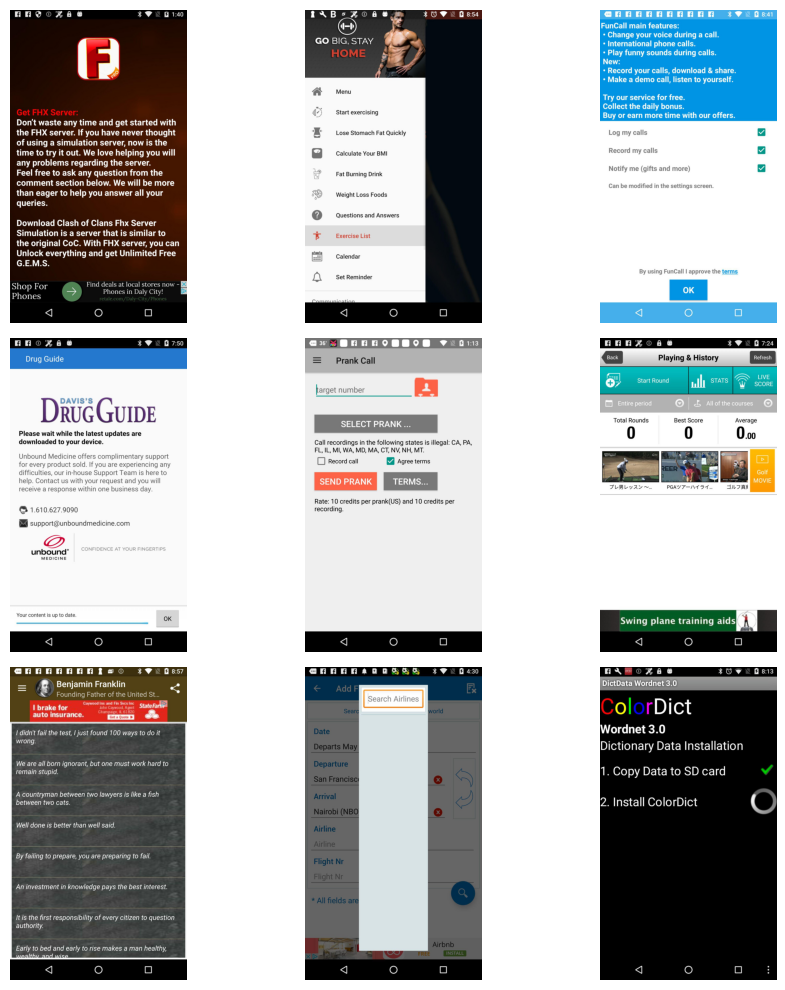

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Create a new figure
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the image paths and plot them
for i, json_path in enumerate(all_json_paths[:9]):
    img = Image.open(DATASET_FOLDER + json_path.replace(".json", ".jpg"))
    axs[i // 3, i % 3].imshow(img)
    axs[i // 3, i % 3].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
with open (DATASET_FOLDER + all_json_paths[0], "r") as f:
  content = f.read()
  print(content)

{
  "activity_name": "com.fhxserver.forcocpro/com.fhxserver.forcocpro.FHxServerCOC4", 
  "activity": {
    "root": {
      "scrollable-horizontal": false, 
      "draw": true, 
      "ancestors": [
        "android.widget.FrameLayout", 
        "android.view.ViewGroup", 
        "android.view.View", 
        "java.lang.Object"
      ], 
      "clickable": false, 
      "pressed": "not_pressed", 
      "focusable": false, 
      "long-clickable": false, 
      "enabled": true, 
      "bounds": [
        0, 
        0, 
        1440, 
        2392
      ], 
      "visibility": "visible", 
      "content-desc": [
        null
      ], 
      "rel-bounds": [
        0, 
        0, 
        1440, 
        2392
      ], 
      "focused": false, 
      "selected": false, 
      "scrollable-vertical": false, 
      "children": [
        {
          "scrollable-horizontal": false, 
          "draw": true, 
          "ancestors": [
            "android.view.ViewGroup", 
            "android.view

In [ ]:
print(process_rico_json_file(DATASET_FOLDER + all_json_paths[0]))

policy.PhoneWindow$DecorView { widget.LinearLayout { view.ViewStub widget.FrameLayout { widget.LinearLayout { widget.LinearLayout { widget.ImageView } widget.LinearLayout { widget.TextView } widget.LinearLayout { ads.AdView { internal.bp { webview.n { webview.o } } } } } } } }


### Find max sentence length and new unknown tokens, filter files bigger than max sentence len

In [ ]:
# Find max length
max_length = 0
filtered_paths = []

# Read text files and add new tokens to dictionary
tokens_to_add = set()
for json_file_path in all_json_paths:
    processed_content = process_rico_json_file(DATASET_FOLDER + json_file_path)
    splitted_text = processor.tokenizer(processed_content).tokens()
    # Check if the current sentence has the largest number of tokens
    if len(splitted_text) > max_length:
        max_length = len(splitted_text)

    if len(splitted_text) <= MAX_SENTENCE_LEN:
        filtered_paths.append(json_file_path.replace(".json",""))
        tokens_to_add = tokens_to_add.union(set(splitted_text))

print(f"Max sentence length = {max_length}")

newly_added_num = processor.tokenizer.add_tokens(list(tokens_to_add))
print(f"Number of new tokens = {newly_added_num}")

# Resize the model's token embeddings if there are new tokens
if newly_added_num > 0:
    model.decoder.resize_token_embeddings(len(processor.tokenizer), pad_to_multiple_of=8)

Max sentence length = 2698
Number of new tokens = 0


In [ ]:
# Keep only the samples with number of tokens lower than Max Sentence Length
all_paths = filtered_paths

In [ ]:
print(len(all_paths))

12480


In [ ]:
print(all_paths[:5])

['57692', '68508', '36027', '34083', '24439']


### Split files into training - validation - test sets

In [ ]:
random.seed(RANDOM_SEED)

# Use the same seed, so that parts remain the same
random.shuffle(all_paths)

train_len = int(TRAIN_SET_PERCENTAGE * len(all_paths))
valid_len = int(VALID_SET_PERCENTAGE * len(all_paths))

train_paths = all_paths[:train_len]
valid_paths = all_paths[train_len:train_len+valid_len]
test_paths = all_paths[train_len+valid_len:]

print(f"TRAIN_SET size = {len(train_paths)}")
print(f"VALID_SET size = {len(valid_paths)}")
print(f"TEST_SET size = {len(test_paths)}")

TRAIN_SET size = 11207
VALID_SET size = 24
TEST_SET size = 1249


In [ ]:
test_paths = test_paths[:125]
print(f"TEST_SET size = {len(test_paths)}")

TEST_SET size = 125


In [ ]:
class RicoDataset(Dataset):
    def __init__(self, root_dir, transform, paths):

        self.root_dir = root_dir
        self.transform = transform
        self.paths = paths

        self.max_patches = MAX_PATCHES
        self.max_length = MAX_SENTENCE_LEN
        self.ignore_id = -100

        self.encodings = []

        for path in tqdm(paths):
            # Directly process the text files, and save them in the ram
            # Do the same also for images, if there is enough space in memory
            text_file_path = os.path.join(root_dir + path + ".json")
            image_file_path = os.path.join(root_dir + path + ".jpg")

            # Load image
            image = Image.open(image_file_path).convert('RGB')

            if DEBUG:
                image.show()

            if self.transform:
                image = self.transform(image)

            encoding = processor(images=image, max_patches=self.max_patches, return_tensors="pt")
            encoding = {k:v.squeeze() for k,v in encoding.items()}

            # Load text
            processed_text_content = process_rico_json_file(text_file_path)

            input_ids = processor.tokenizer(
                processed_text_content,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            ).input_ids

            labels = input_ids.squeeze().clone()
            labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token

            encoding["labels"] = labels.to(torch.int32)

            # For each sample save directly the encoding of both text and image
            self.encodings.append(encoding)

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        return self.encodings[idx], self.paths[idx]


In [ ]:
# Transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize for pretrained models
])

# Instantiate the CustomDataset
test_dataset = RicoDataset(DATASET_FOLDER, transform, test_paths)

# Use DataLoader for batching and shuffling
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 125/125 [00:07<00:00, 15.75it/s]


In [ ]:
print(f"test_dataloader size = {len(test_dataloader)}")

test_dataloader size = 13


In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
encoding, text_file_paths = batch

In [ ]:
print(len(encoding))

3


In [ ]:
print(text_file_paths)

('18495', '7488', '35377', '34837', '42767', '50325', '30800', '54635', '56013', '10096')


### Main Testing function

In [ ]:
START_TOKEN_ID = PAD_TOKEN_ID = processor.tokenizer.pad_token_id

In [ ]:
def testing_loop(testing_dataloader, model, processor, config, description, generation_config, do_sample):
    if (generation_config):
        print("using custom generation config in testing loop: \n")
        print(generation_config)
    if (do_sample):
        print("\nusing sampling\n")

    model.eval()
    bleu_scores = []
    ed_scores = []

    with torch.no_grad():
        test_loop = tqdm(enumerate(testing_dataloader), total=len(testing_dataloader), desc=description)
        for i, batch in test_loop:
            encoding, text_file_paths = batch
            encoding = move_to_device(encoding)
            labels, flattened_patches, attention_mask = encoding["labels"], encoding["flattened_patches"], encoding["attention_mask"]

            # Initialize total_outputs with zeros
            total_outputs = None
            context_from_last = None

            # Initialize a mask to track which sentences are finished
            finished_sentences_mask = torch.zeros(flattened_patches.size(0), dtype=torch.bool, device=flattened_patches.device)

            for iteration in range(MAX_N_CHUNKS_PER_SENTENCE):

                generate_args = {
                    "flattened_patches": flattened_patches[~finished_sentences_mask],
                    "attention_mask": attention_mask[~finished_sentences_mask],
                    "max_new_tokens": CHUNK_LENGTH - (CONTEXT_OVERLAP_LENGTH if iteration else 0),
                    "do_sample": do_sample
                }

                if iteration and context_from_last is not None:
                    generate_args["decoder_input_ids"] = context_from_last[~finished_sentences_mask]

                outputs = model.generate(**generate_args)

                # Remove context overlap only from the second iteration onwards
                new_chunks = outputs if iteration == 0 else outputs[:, CONTEXT_OVERLAP_LENGTH:]

                if iteration == 0:
                    total_outputs = new_chunks
                else:
                    # Update total_outputs by concatenating new chunks
                    new_chunks_with_padding_chunks = torch.full((flattened_patches.shape[0], new_chunks.shape[1]), PAD_TOKEN_ID, dtype=new_chunks.dtype, device=new_chunks.device)
                    new_chunks_with_padding_chunks[~finished_sentences_mask] = new_chunks
                    total_outputs = torch.cat((total_outputs, new_chunks_with_padding_chunks), dim=1)

                # Update the finished_sentences_mask
                finished_sentences_mask[~finished_sentences_mask] |= (outputs == processor.tokenizer.eos_token_id).any(dim=1)

                # If all sentences are finished, exit the loop
                if finished_sentences_mask.all():
                    break

                if outputs.shape[1] < CHUNK_LENGTH:
                    print("ERROR: !! should have already exited because all sentences reached the end!!")

                # -1 because it will put in front a START_TOKEN automatically
                context_from_last = total_outputs[:, -(CONTEXT_OVERLAP_LENGTH-1):]

            predictions = processor.tokenizer.batch_decode(total_outputs, skip_special_tokens=True)

            labels[labels == -100] = 0
            answers = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

            for pred, answer, text_file_path in zip(predictions, answers, text_file_paths):
                with open(f"{OUTPUT_FOLDER}/{text_file_path}_pred.txt", "w") as f:
                    print(pred, file=f)

                with open(f"{OUTPUT_FOLDER}/{text_file_path}_answer.txt", "w") as f:
                    print(answer, file=f)
    return

In [ ]:
config = {
          "verbose": VERBOSE,
}

In [ ]:
def validate_config(config):
    # Check required keys
    required_keys = [
        "verbose"
    ]
    for key in required_keys:
        if key not in config:
            raise ValueError(f"Key '{key}' must be present in the configuration.")

    # Check that values are in expected ranges
    if not isinstance(config["verbose"], bool):
        raise ValueError("verbose must be a boolean value.")

In [ ]:
validate_config(config)
print(config)

{'verbose': True}


### Utility functions

In [ ]:
def move_to_device(data):
    if isinstance(data, (list,tuple)):
        return [move_to_device(x) for x in data]
    elif isinstance(data, dict):
        return {k: move_to_device(v) for k, v in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.to(DEVICE)
    else:
        return data

## Test the model

In [ ]:
def test_model(config, processor, model):
    print("Loading model from checkpoint: ", LAST_CHECKPOINT_NAME)
    checkpoint = torch.load(G_DRIVE_FOLDER_CHECKPOINTS + LAST_CHECKPOINT_NAME)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE)

    generation_config = GenerationConfig.from_model_config(model.config)
    generation_config.repetition_penalty = 1.3
    generation_config.top_k = 10
    generation_config.temperature = 0.9

    testing_loop(test_dataloader, model, processor, config, f"Test loop", generation_config=generation_config, do_sample=True)

In [ ]:
test_model(config, processor, model)

Loading model from checkpoint:  Pix2Struct_Rico_Complete_epoch[14].pth
using custom generation config in testing loop: 

GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "repetition_penalty": 1.3,
  "temperature": 0.9,
  "top_k": 10,
  "transformers_version": "4.33.1",
  "use_cache": false
}


using sampling



Test loop: 100%|██████████| 13/13 [19:10<00:00, 88.51s/it]
